This notebook implements regression on the first round results with cross validation.

## Pipeline

- Data pre-processing: run codes/data_generating.py
- Reading data: read data/firstRound_4h.csv into pandas dataframe
- Cross validation: training (training, validating); testing, KFold (K = ?)
    - Emdedding
        - Onehot
        - Label 
    - Kernel
        - RBF
        - DotProduct
        - Spectrum 
            - lmer: l = ?
            - Padding_flag: add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ'
            - gap_flag:add gapped features, e.g. 3-mer-1-gap
            - normalised_kernel: e.g. zero-mean, unit-norm, unit-var
        - Sum of Spectrum
            - a K_A + b K_B + c K_C, where a + b + c = 1
    - Regression model
        - Gaussian process regression 
            - alpha: scalar value add to diagonal 
            - heteroscedastic: noises are learned as well (same as normalise each replicates to have same derivatives)
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

## Splitting in terms of sequences vs samples?

For each sequence, we have at least three biological replicates. There are two ways splitting data into training and testing data: splitting in terms of sequences, where if one sequence is split into the training dataset, then all replicates of that sequences belong to the training dataset; splitting in terms of samples, where the replicates of one sequence can be in the training or testing dataset. The two methods both make sense in terms of the evaluation of Gaussian process regression.

Considering the goal is to design good sequences for the second round experiment, we expect for training, we do not have any information about the sequences in the testing dataset. That is, splitting in terms of sequences can better simulate the sequence design task. 

In this notebook, we show both two methods of splitting data. We expect that splitting in terms of samples provide a lower error in testing data since the model may have seen the sequences. The test error of splitting sequences should have higher variance, since the prediction depends on whether the sequences in test dataset similar to the sequences in the training dataset. But again, our goal is to decrease the test error as well as the variance for the case of splitting sequences. 

## Evaluate on samples vs sample mean?

For training, we use the samples as labels, since we model the label for each sequence as samples from a unknown (Gaussian) reward distribution.

For testing, we use the sample mean for the sequence (i.e. mean value of the three replicates) as label. The ideal label should be the true mean of underlying distribution (we assume is Gaussian) of a sequence, however, we do not know the true mean. The only choice is to use the sample mean to approximate the true mean, which has the risk the sample mean would deviate a lot from the true mean since the number of samples is quite low (and variance of samples is not low). 

## Choices to make within cross validation 

- alpha: scalar value add to diagonal 
- kernel
- lmer: l = ?
- For Sum_Spectrum_Kernel: b for (1 - b)/2 K_A + b K_B + (1-b)/2 K_C

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

In [3]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.001447,0.263620


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(176, 12)

(array([ 4.,  6., 17., 15., 16., 29., 40., 33., 14.,  2.]),
 array([-2.43313965, -2.00169637, -1.57025309, -1.13880982, -0.70736654,
        -0.27592326,  0.15552001,  0.58696329,  1.01840657,  1.44984984,
         1.88129312]),
 <a list of 10 Patch objects>)

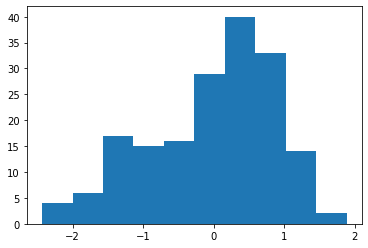

In [5]:
plt.hist(df['AVERAGE'])

## Repeated KFold for sequences

In [6]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = mean_squared_error

gpr = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, normalise_kernel = True)

In [7]:
num_split = 5
num_repeat = 2
s_list = [0,1,2]
# alpha_list= [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
alpha_list = [0.1, 1]
#l_lists = [[3], [4], [5], [6]]
l_lists = [[3],[6]]

result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                      l_lists = l_lists, s_list = s_list)

calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating 

kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all s

kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all s

Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
calculating kernel_all
kernel_all shape:  (735, 735)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
calculating kernel_all
kernel_all shape:  (740, 740)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normalisation
1
Final normalisation
1
Final normalisation
2
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
calculating kernel_all
kernel_all shape:  (739, 739)
Final normalisation
1
Final normal

In [8]:
import pickle

with open('repeated_kfold_wd_shift.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('repeated_kfold_wd_shift.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [9]:
result_pkl.loc[dict(train_test = 'Train')]

<xarray.DataArray (alpha: 2, l: 2, s: 3, num_repeat: 2, num_split: 5)>
array([[[[[0.10816543, 0.12890189, 0.10770801, 0.12048116, 0.10797779],
          [0.12638239, 0.11020084, 0.10407392, 0.1201655 , 0.13066137]],

         [[0.13364454, 0.15286936, 0.10945536, 0.1197184 , 0.09814776],
          [0.12616974, 0.1235269 , 0.12431353, 0.12666603, 0.13072   ]],

         [[0.10942767, 0.15087847, 0.14987718, 0.13975111, 0.11845307],
          [0.12122582, 0.13520875, 0.09805682, 0.13901875, 0.15491988]]],


        [[[0.02650683, 0.02541241, 0.02541292, 0.02760257, 0.01939752],
          [0.02262746, 0.03005809, 0.02619513, 0.01654967, 0.02662775]],

         [[0.03003868, 0.02353892, 0.02512525, 0.03194975, 0.02587311],
          [0.02541818, 0.02380661, 0.0231043 , 0.02914662, 0.0326864 ]],

         [[0.0293658 , 0.03230435, 0.0235358 , 0.03148882, 0.02351472],
          [0.02308596, 0.03280069, 0.0354113 , 0.02479822, 0.03101802]]]],



       [[[[0.27154455, 0.29536858, 0.33075513, 0.30290298, 0.32763274],
          [0.29654218, 0.29775485, 0.28592287, 0.34458552, 0.30427763]],

         [[0.30023122, 0.311476  , 0.36498784, 0.26896313, 0.32223487],
          [0.31752984, 0.28219156, 0.36249186, 0.32742653, 0.30372417]],

         [[0.35610683, 0.28642114, 0.31400132, 0.34574955, 0.32707094],
          [0.33579382, 0.28467096, 0.30661568, 0.33576125, 0.35714114]]],


        [[[0.1911827 , 0.20124649, 0.20956421, 0.18272458, 0.19833474],
          [0.20327967, 0.19944347, 0.17355811, 0.22268914, 0.18730564]],

         [[0.19656827, 0.19527611, 0.21940209, 0.20816838, 0.21376066],
          [0.22856988, 0.20304888, 0.21787365, 0.18687453, 0.18795947]],

         [[0.1963783 , 0.20617386, 0.21839507, 0.19887596, 0.2168067 ],
          [0.21036657, 0.21430089, 0.21195364, 0.21925864, 0.19716217]]]]])
Coordinates:
    train_test  <U5 'Train'
  * alpha       (alpha) float64 0.1 1.0
  * l           (l) <U3 '[3]' '[6]'
  * s           (s) int64 0 1 2
  * num_repeat  (num_repeat) int64 0 1
  * num_split   (num_split) int64 0 1 2 3 4
Attributes:
    eva_metric:  <function mean_squared_error at 0x7fe026060ae8>

In [10]:
result_DataArray[1].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (alpha: 2, l: 2, s: 3)>
array([[[0.8750114 , 0.99518935, 1.03858478],
        [0.8133993 , 0.84400394, 0.86557086]],

       [[0.64813871, 0.68744266, 0.66463914],
        [0.6489584 , 0.6407722 , 0.68151001]]])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) float64 0.1 1.0
  * l           (l) <U3 '[3]' '[6]'
  * s           (s) int64 0 1 2

In [12]:
result_test_s0_aveSplit_aveRepeat = result_DataArray[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_DataArray[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_DataArray[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,6]

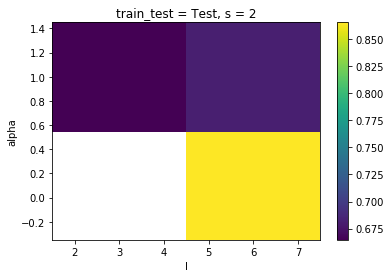

In [14]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()